# Step 1: Ejecutando un árbol

In [28]:
# Librerías necesarias
require("data.table")
require("rpart")
require("ggplot2")
require("geometry")


Loading required package: geometry



In [2]:
# Aqui se debe poner la carpeta de la materia de SU computadora local
setwd("C:/Users/German/Desktop/dmeyf2023/German/Clase 1") # Establezco el Working Directory

# Poner sus semillas
semillas <- c(279511, 279523, 279541, 279551, 279571)

# Cargamos el dataset
dataset <- fread("competencia_01.csv")
dtrain <- dataset[foto_mes == 202103]

In [3]:
# Generamos el primer modelo
arbol <- rpart(formula =    "clase_ternaria ~ .",
                 data =      dtrain,
                 xval =      0,
                 cp =       -0.3,
                 minsplit =  0,
                 minbucket = 1,
                 maxdepth =  4)

print(arbol)


n= 163324 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 163324 2012 CONTINUA (0.0058962553 0.0064228160 0.9876809287)  
   2) ctrx_quarter< 17.5 10372  927 CONTINUA (0.0433860393 0.0459892017 0.9106247590)  
     4) mcuentas_saldo< -1388.155 3869  620 CONTINUA (0.0754716981 0.0847764280 0.8397518739)  
       8) mprestamos_personales< 6627.825 2901  599 CONTINUA (0.0965184419 0.1099620820 0.7935194760)  
        16) cdescubierto_preacordado< 0.5 313  140 CONTINUA (0.1565495208 0.2907348243 0.5527156550) *
        17) cdescubierto_preacordado>=0.5 2588  459 CONTINUA (0.0892581144 0.0880989181 0.8226429675) *
       9) mprestamos_personales>=6627.825 968   21 CONTINUA (0.0123966942 0.0092975207 0.9783057851)  
        18) Visa_status>=8 7    4 CONTINUA (0.2857142857 0.2857142857 0.4285714286) *
        19) Visa_status< 8 961   17 CONTINUA (0.0104058273 0.0072840791 0.9823100937) *
     5) mcuentas_saldo>=-1388.155 6503  307 CONTINUA (0.0242964785 0.022912

Preguntas
Usualmente se suele cortar las variables en 2 intervalos
 - ¿Se podría cortar en más intervalos?
 - ¿Cuál sería el costo?
 - ¿Se obtendr.ían mejores resultados?

 Una de las muchas ventajas que tienen los árboles es la simpleza que tienen  para ser implementados en fácilmente en sistemas productivos, dado que la reescritura de las reglas de salida es muy simple

# Step 2: De árbol a tabla

La siguiente función devuelve todas las hojas (nodos terminales) en una tabla para poder analizar mejor nuestro árbol.

In [4]:
tablahojas <- function(arbol, datos, target = "clase_ternaria") {
  # Tomamos la columna con el target
  target_vector <- datos[, get(target)]
  # Tomamos las clases de nuestro target
  classes <- unique(target_vector)
  # Tomamos las posicion de las hojas que aplican a los registro de nuestro ds
  row_leaf <- unique(arbol$where)
  leaves <- data.table(row_frame = row_leaf)
  setkey(leaves,row_frame)
  # Relacion target ~ hojas
  leaves_target <- dcast(
    data.table(
      target = target_vector,
      leaf = arbol$where),
    leaf ~ target, length,
    value.var = "target")
  setkey(leaves_target, leaf)
  # Juntamos todo
  leaves_target <- leaves_target[leaves, nomatch = 0]
  # Sumamos algunas columnas calculadas
  colnames(leaves_target[, classes, with = FALSE])[apply(
    leaves_target[, classes, with = FALSE], 1, which.max)]
  # Clase mayoritaria
  leaves_target[, y := colnames(
                    leaves_target[, classes, with = FALSE]
                  )[apply(leaves_target[, classes, with = FALSE],
                   1, which.max)]]
  # Cantidad de elementos de la hoja
  leaves_target[, TOTAL := unlist(Reduce(function(a, b) Map(`+`, a, b), .SD)),
                 .SDcols = classes]
  leaves_target
}

In [5]:
# Ejecutamos la función sobre nuestro modelo, con nuestros datos
hojas <- tablahojas(arbol, dtrain)
print(hojas[,])

    leaf BAJA+1 BAJA+2 CONTINUA        y TOTAL
 1:    5     49     91      173 CONTINUA   313
 2:    6    231    228     2129 CONTINUA  2588
 3:    8      2      2        3 CONTINUA     7
 4:    9     10      7      944 CONTINUA   961
 5:   12    107    115     2684 CONTINUA  2906
 6:   13      2      2      578 CONTINUA   582
 7:   15      1      0        0   BAJA+1     1
 8:   16     48     32     2934 CONTINUA  3014
 9:   20     12     19      180 CONTINUA   211
10:   21    176    204     7872 CONTINUA  8252
11:   23      7     14      438 CONTINUA   459
12:   24     75     78    12012 CONTINUA 12165
13:   27      2      0        0   BAJA+1     2
14:   28      6     19      894 CONTINUA   919
15:   30    198    215    49773 CONTINUA 50186
16:   31     37     23    80698 CONTINUA 80758


Preguntas
 - ¿Con qué criterio eligió la clase de cada hoja que determino la clasificación de los registros?
 - ¿Cuántas hojas con BAJAS+2 hay?


# Step 3: Calculando la ganancia de cada hoja

In [6]:
# Agregamos un nuevo campo de nombre ganancia
hojas[, ganancia := `BAJA+2` * 273000 - 7000 * (CONTINUA + `BAJA+1`)]
print(hojas)

    leaf BAJA+1 BAJA+2 CONTINUA        y TOTAL   ganancia
 1:    5     49     91      173 CONTINUA   313   23289000
 2:    6    231    228     2129 CONTINUA  2588   45724000
 3:    8      2      2        3 CONTINUA     7     511000
 4:    9     10      7      944 CONTINUA   961   -4767000
 5:   12    107    115     2684 CONTINUA  2906   11858000
 6:   13      2      2      578 CONTINUA   582   -3514000
 7:   15      1      0        0   BAJA+1     1      -7000
 8:   16     48     32     2934 CONTINUA  3014  -12138000
 9:   20     12     19      180 CONTINUA   211    3843000
10:   21    176    204     7872 CONTINUA  8252    -644000
11:   23      7     14      438 CONTINUA   459     707000
12:   24     75     78    12012 CONTINUA 12165  -63315000
13:   27      2      0        0   BAJA+1     2     -14000
14:   28      6     19      894 CONTINUA   919   -1113000
15:   30    198    215    49773 CONTINUA 50186 -291102000
16:   31     37     23    80698 CONTINUA 80758 -558866000


Pregunta
- ¿Cuantás hojas que no son BAJA+2 tienen aún así ganancia positiva?

# Step 4: Sumarizando el envío

In [7]:
print(hojas[ganancia > 0, .(
    ganancia = sum(ganancia),
    enviados = sum(TOTAL),
    sevan = sum(`BAJA+2`))])

   ganancia enviados sevan
1: 85932000     6484   469


 Preguntas
 Si enviaramos todos los casos de las hojas con ganancia positiva
 - ¿Cuánta ganancia tendríamos?
 - ¿Cuánta personas estimularíamos?
 - ¿A cuántas personas acertaríamos?

# Step 5: Binarizando la salida (en tu cara RAE)

In [8]:
# Creamos un nuevo target binario

dtrain[, clase_binaria := ifelse(
                            clase_ternaria == "BAJA+2",
                                "evento",
                                "noevento"
                            )]

In [9]:
# Borramos el target viejo
dtrain[, clase_ternaria := NULL]

In [10]:
arbolbinario <- rpart("clase_binaria ~ .",
                 data =      dtrain,
                 xval =      0,
                 cp =       -0.3,
                 minsplit =  0,
                 minbucket = 5,
                 maxdepth =  4)

In [11]:
# Transformamos las hojas a una tabla
hojasbinario <- tablahojas(arbolbinario, dtrain, "clase_binaria")

In [12]:
# Y agregamos la ganancia de cada hoja
hojasbinario[, ganancia := evento * 273000 - 7000 * noevento]
print(hojasbinario)
# Por último sumarizamos
print(hojasbinario[ganancia > 0,
 .(ganancia = sum(ganancia), enviados = sum(TOTAL), sevan = sum(evento))])

    leaf evento noevento        y TOTAL   ganancia
 1:    5     14        6   evento    20    3780000
 2:    6    100      528 noevento   628   23604000
 3:    8      3        5 noevento     8     784000
 4:    9      2      430 noevento   432   -2464000
 5:   12    264     2717 noevento  2981   53053000
 6:   13      7     1008 noevento  1015   -5145000
 7:   15     24      562 noevento   586    2618000
 8:   16     63     4639 noevento  4702  -15274000
 9:   20      7        5   evento    12    1876000
10:   21      1       12 noevento    13     189000
11:   23      4        7 noevento    11    1043000
12:   24     30     1224 noevento  1254    -378000
13:   27    179     6495 noevento  6674    3402000
14:   28    112    13942 noevento 14054  -67018000
15:   30    219    51103 noevento 51322 -297934000
16:   31     20    79592 noevento 79612 -551684000
   ganancia enviados sevan
1: 90349000    10933   596


 Pregunta
 - ¿Considera que la agrupación de clases fue positiva para la  ganancia?

# Step 6: Salida probabilísticas

Calculamos la probabilidad de evento en cada hoja

In [13]:
hojasbinario[, p_evento := evento / (evento + noevento)]

Ordenamos de forma descendiente las probabilidades, ya que nos interesan ante todo las probabilidades más altas

In [14]:
hojasordenadas <- hojasbinario[order(-p_evento),]

Calculamos la ganancia acumulada, desde con la probabilidad desde la primera fila con probabilidad más alta hasta la fila N, para cada fila.

In [15]:
hojasordenadas[, gan_acum := cumsum(ganancia)]

print(hojasordenadas)

    leaf evento noevento        y TOTAL   ganancia     p_evento   gan_acum
 1:    5     14        6   evento    20    3780000 0.7000000000    3780000
 2:   20      7        5   evento    12    1876000 0.5833333333    5656000
 3:    8      3        5 noevento     8     784000 0.3750000000    6440000
 4:   23      4        7 noevento    11    1043000 0.3636363636    7483000
 5:    6    100      528 noevento   628   23604000 0.1592356688   31087000
 6:   12    264     2717 noevento  2981   53053000 0.0885608856   84140000
 7:   21      1       12 noevento    13     189000 0.0769230769   84329000
 8:   15     24      562 noevento   586    2618000 0.0409556314   86947000
 9:   27    179     6495 noevento  6674    3402000 0.0268204975   90349000
10:   24     30     1224 noevento  1254    -378000 0.0239234450   89971000
11:   16     63     4639 noevento  4702  -15274000 0.0133985538   74697000
12:   28    112    13942 noevento 14054  -67018000 0.0079692614    7679000
13:   13      7     1008 

 Preguntas:
 - Puede pasar que dos hojas tengan la misma probabilidad?
 - ¿Cómo ve la relación entre la probabilidad ordenada y la hojas con ganancia?
 - ¿Cuál es la máxima ganancia posible es nuestro árbol?
 - ¿Cuál es el `punto de corte` que sugiere?
 - ¿Por qué es distinto al teórico?
 - ¿Es nuestro `punto de corte` es igual de útil?

# Step 7: Graficando la ganancia

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


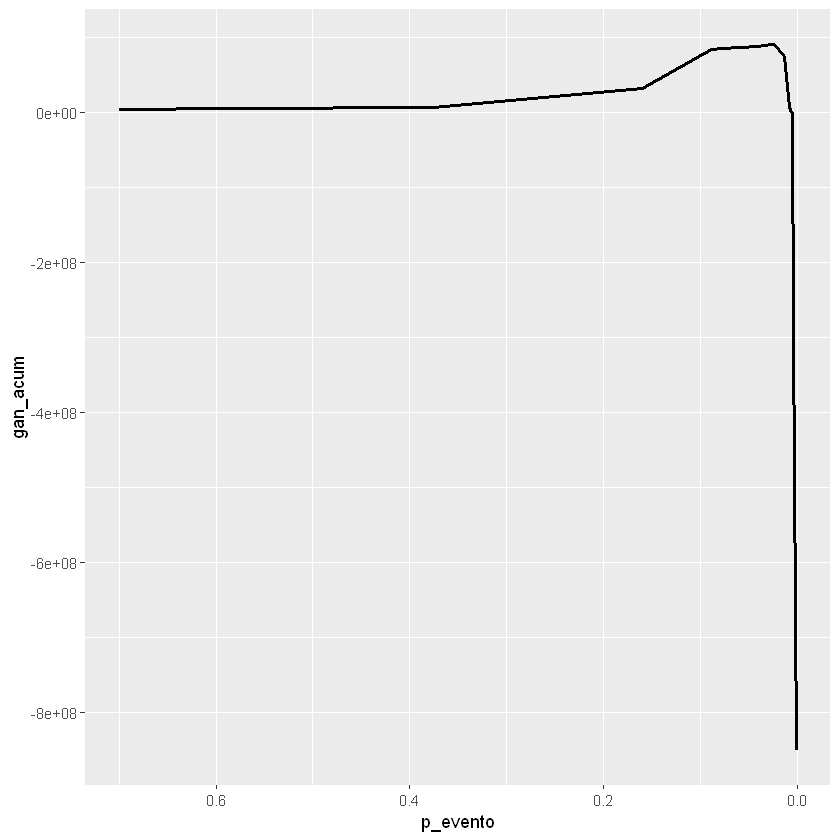

In [22]:
ggplot(hojasordenadas, aes(x = p_evento ,y = gan_acum)) +
     scale_x_reverse() +
     geom_line(size = 1)

 Pregunta
 - ¿Cómo interpretamos este gráfico?

# Step 8: No todo es plata en la vida


`NOTA`:
Existen más formas de medir la calidad del modelo a través de las probabilidades que nos entrega. 
A nivel global podemos usar AUC: área bajo la curva ROC:https://en.wikipedia.org/wiki/Receiver_operating_characteristic que nos muestra el comportamiento global de la performance del modelo.
Para la **curva ROC** vamos a necesitar construir una Matriz de confusión https://en.wikipedia.org/wiki/Confusion_matrix por cada punto de corte posible.

In [23]:
# Vamos a sumar las variables `tp`, `tn`, `fp` y `fn`
hojasordenadas[, c("evento_acum","noevento_acum") :=
                  list(cumsum(evento),cumsum(noevento))]
total_evento <- hojasordenadas[, sum(evento)]
total_noevento <- hojasordenadas[, sum(noevento)]
hojasordenadas[, c("evento_restantes", "noevento_restantes") :=
            list(total_evento - evento_acum, total_noevento - noevento_acum)]

hojasordenadas[, tp := evento_acum]
hojasordenadas[, tn := noevento_restantes]
hojasordenadas[, fp := noevento_acum]
hojasordenadas[, fn := evento_restantes]

In [24]:
# Para validar los cálculos anteriores vamos a visualizar solo los campos importantes
print(hojasordenadas[, .(p_evento, evento, noevento, tp, tn, fp, fn)])

        p_evento evento noevento   tp     tn     fp   fn
 1: 0.7000000000     14        6   14 162269      6 1035
 2: 0.5833333333      7        5   21 162264     11 1028
 3: 0.3750000000      3        5   24 162259     16 1025
 4: 0.3636363636      4        7   28 162252     23 1021
 5: 0.1592356688    100      528  128 161724    551  921
 6: 0.0885608856    264     2717  392 159007   3268  657
 7: 0.0769230769      1       12  393 158995   3280  656
 8: 0.0409556314     24      562  417 158433   3842  632
 9: 0.0268204975    179     6495  596 151938  10337  453
10: 0.0239234450     30     1224  626 150714  11561  423
11: 0.0133985538     63     4639  689 146075  16200  360
12: 0.0079692614    112    13942  801 132133  30142  248
13: 0.0068965517      7     1008  808 131125  31150  241
14: 0.0046296296      2      430  810 130695  31580  239
15: 0.0042671759    219    51103 1029  79592  82683   20
16: 0.0002512184     20    79592 1049      0 162275    0


# Step 9: Armando nuestra curva ROC

In [25]:
# Calculamos las variables necesarios para la curva ROC
hojasordenadas[, tpr := (tp / (tp + fn))]
hojasordenadas[, fpr := (fp / (fp + tn))]

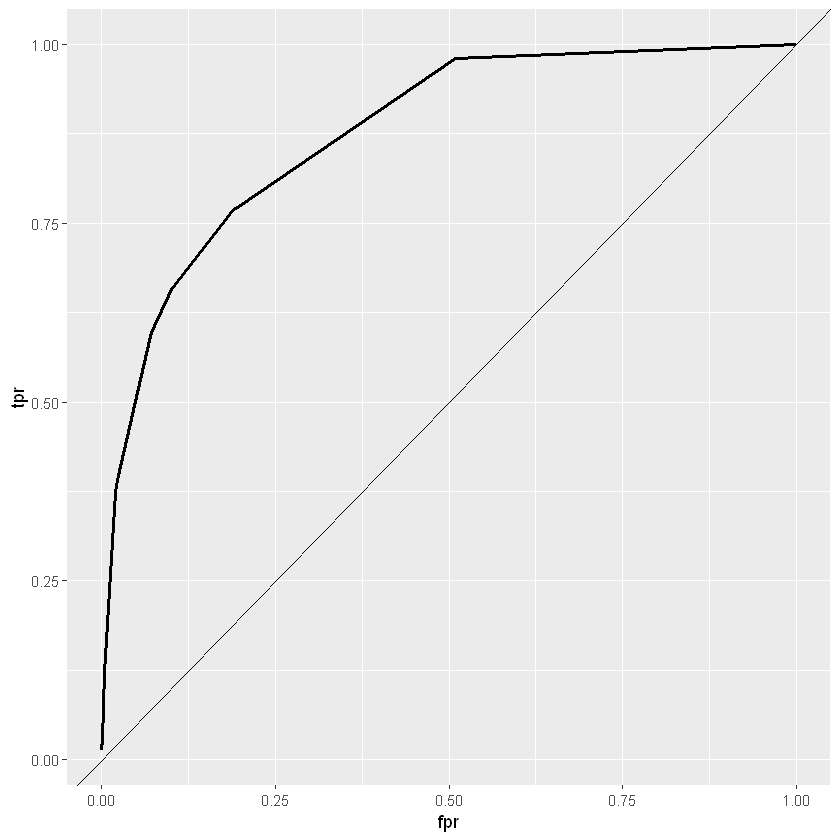

In [26]:
# La graficamos
ggplot(hojasordenadas, aes(x = fpr, y = tpr)) +
  # Agregamos la función identidad
  geom_abline(intercept = 0, slope = 1) +
  geom_line(lwd = 1)

Pregunta
- ¿Qué representa la curva ROC?

# Step 10: Calculando el área bajo la curva

`NOTA`: Como es muy complejo reflejar en palabras una curva, se suele calcular el área bajo su curva (auc) y reflejar ese valor como métrica de la calidad del modelo.

In [29]:
# Calculamos su área, con el paquete Geometry
x <- c(hojasordenadas$fpr,1)
y <- c(hojasordenadas$tpr, 0)
# El valor de la auc
print(polyarea(x, y))

[1] 0.8703878


 Pregunta
 - ¿AUC es una métrica global o local?
 - ¿Pueden dos curvas distintas tener un mismo valor de AUC?